## LSTM 사용 Text 분류 모델 구현
: Keras의 Embedding,LSTM,Dropout 계층 사용

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

###  Spam and Ham 분류 테스트 데이터 셋 읽어오기

In [2]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
# ISO/IEC 8859-1, https://ko.wikipedia.org/wiki/ISO/IEC_8859-1
print(df.shape)
print(df['v2'][0], df['v1'][0])
df.head(20)

(5572, 5)
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... ham


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


### 불필요한 컬럼 삭제

In [3]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.head(20)
# df.info()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

### 분포를 시각화

Text(0, 0.5, 'Number of ham and spam messages')

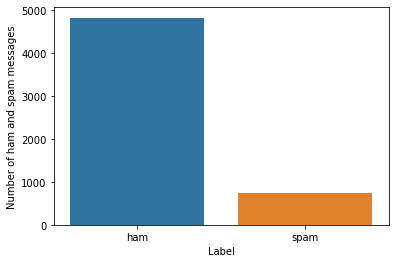

In [5]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.ylabel('Number of ham and spam messages')

### Y 값을 0, 1로 변환 : LabelEncoder()

In [6]:
X = df.v2
Y =df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)   # Y 값이 0,1로 변환, Logistic Regression, sigmoid사용
Y = Y.reshape(-1,1)       # 2차원
print(Y.shape)

(5572, 1)


In [7]:
### train 과 test 데이터 셋으로 분리
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)  # 70:30
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(3900,) (1672,) (3900, 1) (1672, 1)


### 문장을 토큰화 처리, 패딩, 데이터셋의 길이를 설정

In [8]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
#     split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
# )

In [9]:
# 토큰나이저를 시행하여 단어를 숫자값, 인덱스로 변환하여 저장

max_words = 1000
max_len = 150         # 데이터 셋의 길이, 한 문장의 길이, sequence_length: T

tok = Tokenizer(num_words=max_words) # 가장 빈도가 높은 1000 개의 단어들만 사용하여 토큰화

# 단어 인덱스를 구축
tok.fit_on_texts(X_train)   # 범위 : 0 ~ 999

# 문자열을 정수 인덱스의 리스트로 변환
sequences = tok.texts_to_sequences(X_train) # type은 list
sequences[:4]      # 길이가 서로 다름

# 벡터 표현을 얻음
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)  # 신경망에 입력할 X값이다
print(sequences_matrix.shape)  # (3900, 150), 2차원 행렬

word_to_index = tok.word_index
# print(word_to_index)
vocab_size = len(word_to_index)
print(vocab_size)

sequences_matrix

(3900, 150)
7464


array([[  0,   0,   0, ...,   6,   1,  29],
       [  0,   0,   0, ..., 739, 740, 276],
       [  0,   0,   0, ...,  32,  11,  66],
       ...,
       [  0,   0,   0, ...,  21, 662, 446],
       [  0,   0,   0, ...,  95,  56, 146],
       [  0,   0,   0, ...,  70, 384,  20]])

## RNN 신경망 모델 구현

In [10]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
# tf.keras.layers.Embedding(
#     input_dim, output_dim, embeddings_initializer='uniform',
#     embeddings_regularizer=None, activity_regularizer=None,
#     embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
# )

# input_dim : input_dim   , D  , max_words : 1000
# output_dim : hidden_size , H , 50
# input_length : sequence_length , T : max_len:150

In [20]:
# LSTM 1층을 사용하여 신경망을 구현
model = tf.keras.Sequential([
    # (None,1000) * (1000,50) = (None,50) , T:150, (None,150,50)
    tf.keras.layers.Embedding(max_words,50,input_length=max_len), # 3차원으로 출력, (None, 150, 50)
    # (None,150,50), W: (D,H) ==>(50,32)  
    # (None,50) * (50,32) = (None,32) -> (None,150,50) 
    tf.keras.layers.LSTM(32,return_sequences=True),
    # (None,50) * (50,32) = (None,32) -> (None,150,32) 
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),  # (None,150,32)  # 3차원 
    tf.keras.layers.Flatten(),          # (None,150*32) = (None, 4800)  , 2차원
    tf.keras.layers.Dense(1,activation='sigmoid') # (None,1)
])  

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 150, 32)           10624     
_________________________________________________________________
dense_7 (Dense)              (None, 150, 32)           1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 4801      
Total params: 66,481
Trainable params: 66,481
Non-trainable params: 0
__________________________________________________

In [21]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
# RMSProp : https://forensics.tistory.com/28
# RMSprop 알고리즘은 Adadelta와 마찬가지로 Adagrad에서 학습률이 급격하게 감소하는 문제를 해결 

In [22]:
# 학습
model.fit(sequences_matrix,Y_train,batch_size=128, epochs=10, validation_split=0.2)

Train on 3120 samples, validate on 780 samples
Epoch 1/10
3120/3120 [==============================] - 10s 3ms/sample - loss: 0.4114 - accuracy: 0.8337 - val_loss: 0.3718 - val_accuracy: 0.8667
Epoch 2/10
3120/3120 [==============================] - 5s 2ms/sample - loss: 0.2405 - accuracy: 0.9045 - val_loss: 0.1440 - val_accuracy: 0.9603
Epoch 3/10
3120/3120 [==============================] - 5s 2ms/sample - loss: 0.0938 - accuracy: 0.9750 - val_loss: 0.0881 - val_accuracy: 0.9744
Epoch 4/10
3120/3120 [==============================] - 5s 2ms/sample - loss: 0.0660 - accuracy: 0.9808 - val_loss: 0.0692 - val_accuracy: 0.9782
Epoch 5/10
3120/3120 [==============================] - 6s 2ms/sample - loss: 0.0492 - accuracy: 0.9859 - val_loss: 0.0767 - val_accuracy: 0.9769
Epoch 6/10
3120/3120 [==============================] - 6s 2ms/sample - loss: 0.0413 - accuracy: 0.9878 - val_loss: 0.0701 - val_accuracy: 0.9769
Epoch 7/10
3120/3120 [==============================] - 5s 1ms/sample - loss

### 정확도 측정

In [26]:
#  Test 데이터셋의 벡터를 구함

# 문자열을 정수 인덱스의 리스트로 변환
test_sequences = tok.texts_to_sequences(X_test) 

# 벡터 표현을 얻음
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)  # 신경망에 입력할 X값이다
print(test_sequences_matrix.shape,Y_test.shape)  # (1672, 150), 2차원 행렬

(1672, 150) (1672, 1)


In [27]:
# 정확도
accr = model.evaluate(test_sequences_matrix,Y_test) 

1672/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [28]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.080
  Accuracy: 0.984


In [31]:
# 예측
preds = model.predict(test_sequences_matrix[1].reshape(1,-1)) # test_sequences_matrix[1]은 1차원이므로
preds,Y_test[1]

(array([[0.00444937]], dtype=float32), array([0]))

In [33]:
test_sequences_matrix[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       332,   2,  65, 237,  12,  13,  16])

In [34]:
preds = model.predict(test_sequences_matrix[17].reshape(1,-1)) 
preds,Y_test[17]

(array([[0.00221201]], dtype=float32), array([0]))

In [39]:
ones = np.where(Y_test==1)  # 답이 1인 인덱스
ones[0]

array([   0,   23,   33,   35,   49,   57,   70,   73,   75,   83,   84,
         92,   96,   99,  100,  109,  131,  135,  146,  153,  175,  176,
        186,  187,  209,  226,  243,  246,  247,  263,  265,  272,  279,
        282,  300,  302,  310,  312,  317,  328,  333,  341,  345,  350,
        357,  364,  366,  376,  382,  392,  396,  397,  422,  426,  430,
        449,  455,  458,  460,  468,  471,  481,  485,  487,  491,  498,
        506,  512,  523,  527,  531,  533,  549,  551,  555,  556,  557,
        563,  586,  592,  594,  597,  618,  621,  632,  640,  642,  654,
        685,  700,  709,  710,  712,  715,  723,  729,  736,  738,  749,
        755,  779,  789,  792,  796,  811,  815,  832,  862,  868,  881,
        882,  884,  891,  897,  901,  904,  905,  906,  909,  926,  955,
        959,  962,  987, 1002, 1003, 1008, 1013, 1019, 1020, 1021, 1022,
       1023, 1025, 1034, 1049, 1059, 1072, 1073, 1094, 1102, 1106, 1108,
       1116, 1121, 1153, 1154, 1162, 1164, 1167, 11

In [37]:
for one in ones[0]:
    preds = model.predict(test_sequences_matrix[one].reshape(1,-1))
    print(preds,Y_test[one])

[[0.42776358]] [1]
[[0.99999917]] [1]
[[0.99580514]] [1]
[[0.99129665]] [1]
[[0.9994998]] [1]
[[0.9999449]] [1]
[[0.9983015]] [1]
[[0.9999579]] [1]
[[0.9999157]] [1]
[[0.9999435]] [1]
[[1.1495189e-05]] [1]
[[0.99999976]] [1]
[[0.9999964]] [1]
[[0.50932175]] [1]
[[0.9903944]] [1]
[[0.9918771]] [1]
[[0.9996505]] [1]
[[0.9999982]] [1]
[[0.99999917]] [1]
[[0.9998791]] [1]
[[0.9999852]] [1]
[[0.4716571]] [1]
[[0.974831]] [1]
[[0.9999963]] [1]
[[0.9999844]] [1]
[[0.9999373]] [1]
[[0.9995079]] [1]
[[0.99996734]] [1]
[[0.9999951]] [1]
[[0.99906725]] [1]
[[0.9975056]] [1]
[[0.99996674]] [1]
[[0.99999857]] [1]
[[0.9999738]] [1]
[[0.999997]] [1]
[[0.99996734]] [1]
[[0.9578142]] [1]
[[0.99999416]] [1]
[[0.4640143]] [1]
[[0.9996681]] [1]
[[0.0691215]] [1]
[[0.99990416]] [1]
[[0.9996061]] [1]
[[0.9999963]] [1]
[[0.99999976]] [1]
[[0.12905975]] [1]
[[0.07392199]] [1]
[[0.9998914]] [1]
[[0.9999932]] [1]
[[0.99999547]] [1]
[[0.9999584]] [1]
[[0.09745591]] [1]
[[0.9999114]] [1]
[[0.999959]] [1]
[[0.0236